In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error



from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

import random

# 1) Exploratory Data Analysis:  Book Data Set

In [2]:
df_books = pd.read_csv('books.csv')
df_book_tags = pd.read_csv('book_tags.csv')
df_tags  = pd.read_csv ('tags.csv')
df_read= pd.read_csv ('to_read.csv')

In [3]:
df_books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [4]:
df_books.shape

(10000, 23)

In [5]:
df_books.columns

Index(['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn',
       'isbn13', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url'],
      dtype='object')

In [6]:
ratings=pd.read_csv("ratings.csv")
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [7]:
ratings=pd.read_csv("ratings.csv", names=['node1', 'node2', 'weight'], header=0)
ratings.head()

,node1,node2,weight
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [8]:
print(ratings.shape)

(981756, 3)


In [9]:
#check the missing values 
#i should manage the missing values because i plan to use NearestNeighbors that does not support missing values. 
#df_books.isnull().any()

missing = df_books.isnull().sum().sort_values(ascending = False)
missing = missing.reset_index()
#missing['Percent'] = missing.iloc[:, 1].apply(lambda x: x*100/np.sum(missing.iloc[:, 1]))
missing.columns = ['Attributes', 'Missing']
gtz = missing['Missing'] > 0
missing = missing[gtz]
missing

,Attributes,Missing
0,language_code,1084
1,isbn,700
2,isbn13,585
3,original_title,585
4,original_publication_year,21


isbn , isbn13 and the publication year are the columns that i dont want to work  the missing values in these columns are not important so much 
original title and the title columns are correlated so i will drop original title column
i should do some manipulations to manage the missing values in language_code column. 

In [10]:
#i should do some manipulation to language code and i  have made a detailed analyses for that column . 
df_books['language_code'].value_counts()

eng      6341
en-US    2070
en-GB     257
ara        64
en-CA      58
fre        25
ind        21
spa        20
ger        13
jpn         7
per         7
pol         6
por         6
en          4
nor         3
dan         3
fil         2
ita         2
rus         1
rum         1
nl          1
vie         1
swe         1
mul         1
tur         1
Name: language_code, dtype: int64

In [11]:
#i just want to check some other languages 

values= ['jpn','per','pol','vie','rus']

for  value in values:
    print ( value,':')
    print(df_books[df_books['language_code']==value].head(1))

jpn :
        id  book_id  best_book_id   work_id  books_count        isbn  \
2519  2520  6443834       6443834  18525442           76  4103534222   

            isbn13                 authors  original_publication_year  \
2519  9.784104e+12  Haruki Murakami, 村上 春樹                     2009.0   

                        original_title  ... ratings_count work_ratings_count  \
2519  1Q84 Book 1 [Ichi-kyū-hachi-yon]  ...         32323              36769   

      work_text_reviews_count  ratings_1  ratings_2  ratings_3  ratings_4  \
2519                     1280       1325       2014       6601      13628   

      ratings_5                                          image_url  \
2519      13201  https://images.gr-assets.com/books/1329955413m...   

                                        small_image_url  
2519  https://images.gr-assets.com/books/1329955413s...  

[1 rows x 23 columns]
per :
        id  book_id  best_book_id  work_id  books_count        isbn  \
6159  6160   326272         6

In [12]:
#i have decided to create a valid languages set and work with books that are in this set. 
#(the titles should be in latin alphabet)
valid_language=['eng','en-US','en-GB','en-CA','fre','spa','ger']
 
df_books= df_books[df_books.language_code.isin(valid_language)]

i want to checked the corralation in the dataframe and dropped the correlated columns. 

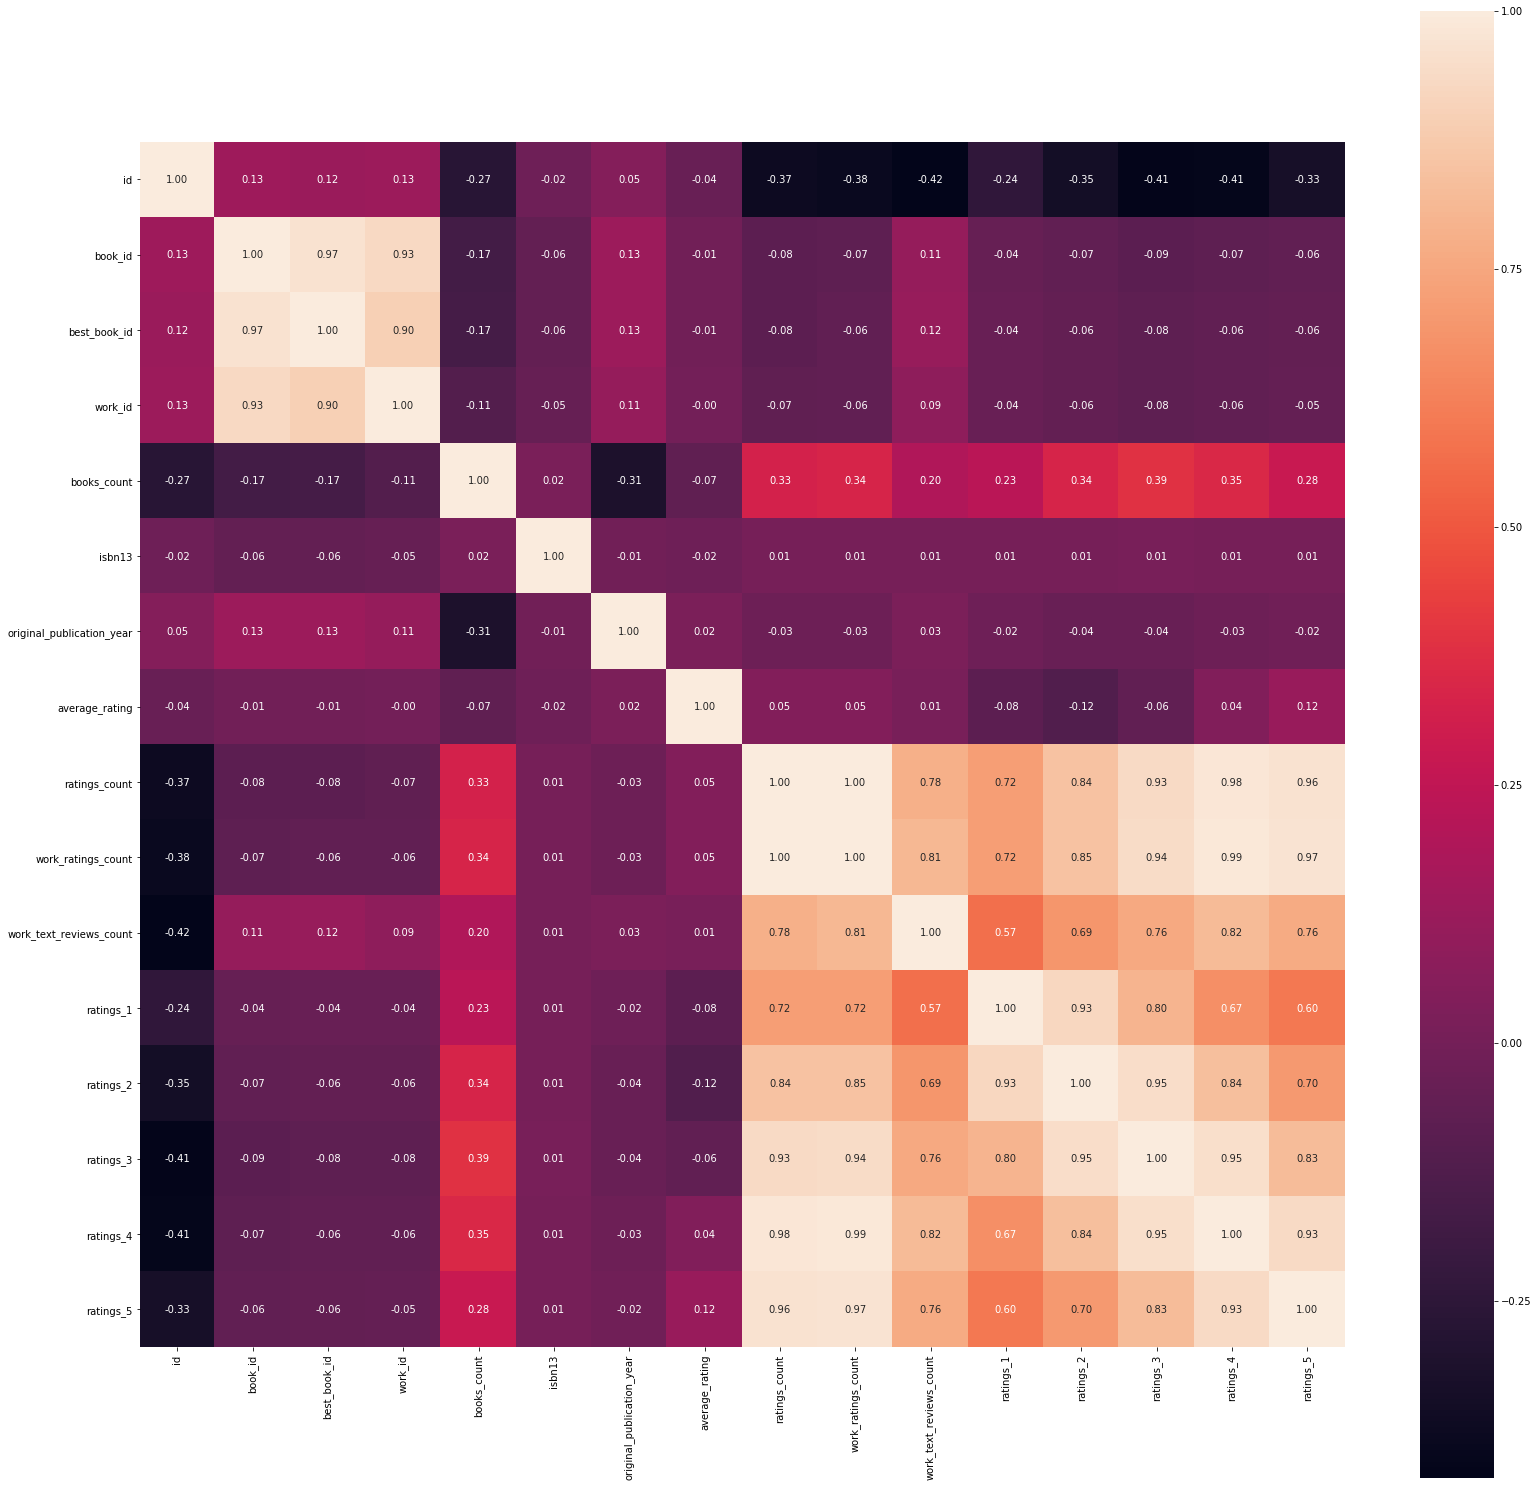

In [13]:
corr = df_books.corr()
plt.figure(figsize=(27,27))
sns.heatmap(corr, cbar = True, 
            square = True, annot=True, fmt= '.2f',
            annot_kws={'size': 10},xticklabels=corr.columns.values,yticklabels=corr.columns.values)
plt.show()



In [14]:
#is there any difference btwn best_book_id and book_id
t= df_books[(df_books['book_id'] )!= (df_books['best_book_id'] )].shape[0]/df_books.shape[0]
if t< 0.10:
    print('drop "best_book_id" column')
else:
    print('do not drop  "best_book_id" column')



drop "best_book_id" column


In [15]:
#i checked the rating informations and decided to use only the avg rating column in the data set
df_books[df_books.id==1].ratings_1  + df_books[df_books.id==1].ratings_2 +df_books[df_books.id==1].ratings_3 +df_books[df_books.id==1].ratings_4 +df_books[df_books.id==1].ratings_5

0    4942365
dtype: int64

Final of the df_books

In [16]:
df_books.columns

Index(['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn',
       'isbn13', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url'],
      dtype='object')

In [17]:
print('the shape of df_book is ', df_books.shape)

df_books = df_books.drop(['id',  'best_book_id', 'work_id', 'books_count', 'isbn',
       'isbn13', 'original_publication_year', 'original_title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url'], axis=1)

print('some columns has been dropped, the shape of df_book is, ', df_books.shape)

print('missing values of df_books ', df_books.isnull().any().sum())

print('data sample from df_book :')

df_books.head(2)


the shape of df_book is  (8784, 23)
some columns has been dropped, the shape of df_book is,  (8784, 3)
missing values of df_books  0
data sample from df_book :


,book_id,authors,title
0,2767052,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)"
1,3,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...


In [17]:
df_ratings =pd.read_csv('ratings_book.csv')
df_ratings.head(2)


,book_id,user_id,rating
0,1,314,5
1,1,439,3


In [18]:
df_ratings.isnull().any().sum()

0

In [19]:
df_ratings.shape

(981756, 3)

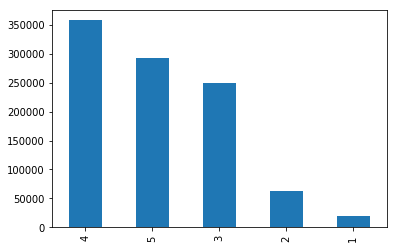

In [31]:
df_ratings["rating"].value_counts().plot(kind="bar")

In [21]:
#df_ratings.user_id.value_counts()

In [21]:
df_books.title.value_counts().head()

Selected Poems    3
Leviathan         2
The Collector     2
'Salem's Lot      2
The Son           2
Name: title, dtype: int64

In [62]:
#authors_recommendations('The Girls').head(10)

# Collaborative Filtering 


In [22]:
df_books.head(2)

,book_id,authors,title
0,2767052,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)"
1,3,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...


In [23]:
df_ratings.head(2)

,book_id,user_id,rating
0,1,314,5
1,1,439,3


In [24]:
merged = pd.merge(left=df_ratings, right=df_books, on="book_id", how="right")
merged.head()

,book_id,user_id,rating,authors,title
0,1,314.0,5.0,"J.K. Rowling, Mary GrandPré",Harry Potter and the Half-Blood Prince (Harry ...
1,1,439.0,3.0,"J.K. Rowling, Mary GrandPré",Harry Potter and the Half-Blood Prince (Harry ...
2,1,588.0,5.0,"J.K. Rowling, Mary GrandPré",Harry Potter and the Half-Blood Prince (Harry ...
3,1,1169.0,4.0,"J.K. Rowling, Mary GrandPré",Harry Potter and the Half-Blood Prince (Harry ...
4,1,1185.0,4.0,"J.K. Rowling, Mary GrandPré",Harry Potter and the Half-Blood Prince (Harry ...


In [25]:
merged.title.tail()

76643                                   Billy Budd, Sailor
76644                            Bayou Moon (The Edge, #2)
76645    Means of Ascent (The Years of Lyndon Johnson, #2)
76646                                The Mauritius Command
76647    Cinderella Ate My Daughter: Dispatches from th...
Name: title, dtype: object

In [26]:
#check and  remove duplicates 

print('Number of dublicates values in merged data: ', merged.duplicated(["user_id", "title"]).sum())

merged.drop_duplicates(["user_id", "title"], keep="first", inplace=True)
print('dublicate values have dropped so tne number of dublicates values in merged data: ', merged.duplicated(["user_id", "title"]).sum())

Number of dublicates values in merged data:  179
dublicate values have dropped so tne number of dublicates values in merged data:  0


In [344]:
#data.groupby('title')['rating'].count().sort_values(ascending=False)

In [27]:
matrix = merged.pivot("user_id","title","rating")


In [28]:
matrix.tail(2)

title,"Angels (Walsh Family, #3)",#GIRLBOSS,'Salem's Lot,"'Tis (Frank McCourt, #2)","10% Happier: How I Tamed the Voice in My Head, Reduced Stress Without Losing My Edge, and Found Self-Help That Actually Works","100 Bullets, Vol. 1: First Shot, Last Call",100 Love Sonnets,100 Selected Poems,"10th Anniversary (Women's Murder Club, #10)","11 Birthdays (Willow Falls, #1)",...,"Zoe's Tale (Old Man's War, #4)",Zone One,Zoo,Zorba the Greek,Zorro,for colored girls who have considered suicide/when the rainbow is enuf,god is Not Great: How Religion Poisons Everything,sTORI Telling,"ttyl (Internet Girls, #1)","xxxHolic, Vol. 1 (xxxHOLiC, #1)"
user_id,,,,,,,,,,,,,,,,,,,,,
53422.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53423.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:

from sklearn.utils import shuffle
matrix = shuffle(matrix)
print(matrix.head(2))
print(matrix.shape )
matrix.index = range(matrix.shape[0])

title     Angels (Walsh Family, #3)  #GIRLBOSS  'Salem's Lot  \
user_id                                                        
51195.0                         NaN        NaN           NaN   
37731.0                         NaN        NaN           NaN   

title    'Tis (Frank McCourt, #2)  \
user_id                             
51195.0                       NaN   
37731.0                       NaN   

title    10% Happier: How I Tamed the Voice in My Head, Reduced Stress Without Losing My Edge, and Found Self-Help That Actually Works  \
user_id                                                                                                                                  
51195.0                                                NaN                                                                               
37731.0                                                NaN                                                                               

title    100 Bullets, Vol. 1: First Shot,

In [290]:
#matrix[matrix['Billy Budd, Sailor']]

In [291]:
#matrix.index==314

In [30]:
#data is too big to work with algorithms. So i have decided to use a sub set of data.   Firt i have shuffled the data and 
#than crated a sampled data  
#if you want to work with all data dont run this cell 
sample_matrix= matrix.iloc[:700]
matrix=sample_matrix 


In [86]:
avg = matrix.mean(axis=1)

In [87]:
avg.head(3)

0    5.0
1    3.0
2    3.5
dtype: float64

In [88]:
#avg_matrix =matrix - np.array(avg).reshape(-1,1)


x= matrix.values - np.array(avg).reshape(-1,1)
y=pd.DataFrame(x)
y.columns = list(matrix.columns)

avg_matrix = y 

In [89]:
avg_matrix.head(2)

,"Angels (Walsh Family, #3)",#GIRLBOSS,'Salem's Lot,"'Tis (Frank McCourt, #2)","10% Happier: How I Tamed the Voice in My Head, Reduced Stress Without Losing My Edge, and Found Self-Help That Actually Works","100 Bullets, Vol. 1: First Shot, Last Call",100 Love Sonnets,100 Selected Poems,"10th Anniversary (Women's Murder Club, #10)","11 Birthdays (Willow Falls, #1)",...,"Zoe's Tale (Old Man's War, #4)",Zone One,Zoo,Zorba the Greek,Zorro,for colored girls who have considered suicide/when the rainbow is enuf,god is Not Great: How Religion Poisons Everything,sTORI Telling,"ttyl (Internet Girls, #1)","xxxHolic, Vol. 1 (xxxHOLiC, #1)"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
avg_matrix.fillna(value=0, inplace = True)
avg_matrix.head()

,"Angels (Walsh Family, #3)",#GIRLBOSS,'Salem's Lot,"'Tis (Frank McCourt, #2)","10% Happier: How I Tamed the Voice in My Head, Reduced Stress Without Losing My Edge, and Found Self-Help That Actually Works","100 Bullets, Vol. 1: First Shot, Last Call",100 Love Sonnets,100 Selected Poems,"10th Anniversary (Women's Murder Club, #10)","11 Birthdays (Willow Falls, #1)",...,"Zoe's Tale (Old Man's War, #4)",Zone One,Zoo,Zorba the Greek,Zorro,for colored girls who have considered suicide/when the rainbow is enuf,god is Not Great: How Religion Poisons Everything,sTORI Telling,"ttyl (Internet Girls, #1)","xxxHolic, Vol. 1 (xxxHOLiC, #1)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
avg_matrix.shape

(700, 8761)

In [92]:
#train ve test diye ayırdı. 
trainSize = 500
train = avg_matrix[:trainSize]
test = avg_matrix[trainSize:]

In [94]:
test.tail(1)

,"Angels (Walsh Family, #3)",#GIRLBOSS,'Salem's Lot,"'Tis (Frank McCourt, #2)","10% Happier: How I Tamed the Voice in My Head, Reduced Stress Without Losing My Edge, and Found Self-Help That Actually Works","100 Bullets, Vol. 1: First Shot, Last Call",100 Love Sonnets,100 Selected Poems,"10th Anniversary (Women's Murder Club, #10)","11 Birthdays (Willow Falls, #1)",...,"Zoe's Tale (Old Man's War, #4)",Zone One,Zoo,Zorba the Greek,Zorro,for colored girls who have considered suicide/when the rainbow is enuf,god is Not Great: How Religion Poisons Everything,sTORI Telling,"ttyl (Internet Girls, #1)","xxxHolic, Vol. 1 (xxxHOLiC, #1)"
699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
test[:1]

,"Angels (Walsh Family, #3)",#GIRLBOSS,'Salem's Lot,"'Tis (Frank McCourt, #2)","10% Happier: How I Tamed the Voice in My Head, Reduced Stress Without Losing My Edge, and Found Self-Help That Actually Works","100 Bullets, Vol. 1: First Shot, Last Call",100 Love Sonnets,100 Selected Poems,"10th Anniversary (Women's Murder Club, #10)","11 Birthdays (Willow Falls, #1)",...,"Zoe's Tale (Old Man's War, #4)",Zone One,Zoo,Zorba the Greek,Zorro,for colored girls who have considered suicide/when the rainbow is enuf,god is Not Great: How Religion Poisons Everything,sTORI Telling,"ttyl (Internet Girls, #1)","xxxHolic, Vol. 1 (xxxHOLiC, #1)"
500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
merged["title"].value_counts().unique()

array([101, 100,  99,  98,  97,  96,  95,  94,  93,  92,  91,  90,  89,
        87,  86,  84,  83,  81,  80,  79,  78,  77,  76,  75,  74,  73,
        71,  70,  69,  68,  60,  59,  58,  57,   1])

In [101]:
test_user_set=[]
for i in range(500):
    userID =i
    bookName = "The List"
    if (matrix.loc[userID, bookName]> 0):
        test_user_set.append(userID)

In [102]:
test_user_set

[101, 151, 157, 413]

In [103]:
userID =101
bookName = "The List"
matrix.loc[userID, bookName ]

5.0

In [142]:
real_ratings=[]
preds=[]
for userID in test.index:
  for movieName in test.columns:
    rating = test.loc[userID, movieName]
    if rating != 0:
      y += 1
      realRating = matrix.loc[userID, movieName]
      ratedUsers = train[train[movieName] != 0 ].index
      k = 2
      neigh = NearestNeighbors(n_neighbors=trainSize, metric="cosine")
      neigh.fit(train) 
      sim_users = neigh.kneighbors(test.loc[userID:userID, :])[1][0]
      sim_values = neigh.kneighbors(test.loc[userID:userID, :])[0][0]
      count = 0
      totalSim = 0
      totalRate = 0
      for i in range(len(sim_users)-1, -1, -1):
        curID = sim_users[i]
        curSim = sim_values[i]

        if curID in ratedUsers:
          totalRate += matrix.loc[curID, movieName] * curSim
          totalSim += curSim
          count += 1
          if count == k:
            break
      if(totalSim !=0 ):
        pred = totalRate / totalSim
        preds.append(pred)
        real_ratings.append(realRating)
      
      

In [109]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(real_ratings,preds)
np.sqrt(mse)

1.3010313951467647

In [144]:
#real_ratings
#preds

[4.0,
 4.0,
 4.0,
 2.9394726587942004,
 4.0,
 4.064926588062426,
 3.0000000000000004,
 4.0,
 4.0345905390678505,
 3.4988524747077427,
 3.9784863665807833,
 3.582105086893709,
 4.578349809696828,
 2.587515630900118,
 5.0,
 4.0619464442287585,
 5.0,
 5.0,
 4.0,
 5.000000000000001,
 4.493612799503593,
 3.0,
 4.999999999999999,
 5.0,
 3.0,
 3.562653566951019,
 3.597404002525264,
 4.0,
 5.0,
 1.9973700189521124,
 3.4890403880009284,
 4.5060940324897185,
 4.622476171295263,
 2.5547082602124194,
 1.0,
 3.59458770469279,
 2.9999999999999996,
 5.0,
 3.6519032059313523,
 5.0,
 5.0,
 5.0,
 3.580712728107934,
 3.0,
 4.491975321406583,
 4.0,
 3.0,
 2.0,
 4.0,
 4.412771184906495,
 3.4559254077659896,
 4.0,
 5.0,
 3.0000000000000004,
 3.0,
 4.0,
 2.0,
 3.0,
 2.040949698733618,
 4.999999999999999,
 4.0,
 5.000000000000001,
 5.0,
 5.0,
 4.51440306348738,
 4.514341706993639,
 2.9999999999999996,
 4.0,
 4.999999999999999,
 3.0,
 3.0,
 3.0209910042643147,
 3.0,
 2.5114031666658874,
 1.9480098484210426,
 4

# SVD

In [110]:
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics.pairwise import cosine_similarity

In [145]:
if(matrix.shape[0]==700):
    print('you are working with sample data set')
else:
    print('you are working with sample data set')

you are working with sample data set


In [114]:
matrix.head(2)

title,"Angels (Walsh Family, #3)",#GIRLBOSS,'Salem's Lot,"'Tis (Frank McCourt, #2)","10% Happier: How I Tamed the Voice in My Head, Reduced Stress Without Losing My Edge, and Found Self-Help That Actually Works","100 Bullets, Vol. 1: First Shot, Last Call",100 Love Sonnets,100 Selected Poems,"10th Anniversary (Women's Murder Club, #10)","11 Birthdays (Willow Falls, #1)",...,"Zoe's Tale (Old Man's War, #4)",Zone One,Zoo,Zorba the Greek,Zorro,for colored girls who have considered suicide/when the rainbow is enuf,god is Not Great: How Religion Poisons Everything,sTORI Telling,"ttyl (Internet Girls, #1)","xxxHolic, Vol. 1 (xxxHOLiC, #1)"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
matrix2 = matrix.fillna(value=0)  
matrix2.tail()

title,"Angels (Walsh Family, #3)",#GIRLBOSS,'Salem's Lot,"'Tis (Frank McCourt, #2)","10% Happier: How I Tamed the Voice in My Head, Reduced Stress Without Losing My Edge, and Found Self-Help That Actually Works","100 Bullets, Vol. 1: First Shot, Last Call",100 Love Sonnets,100 Selected Poems,"10th Anniversary (Women's Murder Club, #10)","11 Birthdays (Willow Falls, #1)",...,"Zoe's Tale (Old Man's War, #4)",Zone One,Zoo,Zorba the Greek,Zorro,for colored girls who have considered suicide/when the rainbow is enuf,god is Not Great: How Religion Poisons Everything,sTORI Telling,"ttyl (Internet Girls, #1)","xxxHolic, Vol. 1 (xxxHOLiC, #1)"
695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
matrix2.shape

(700, 8761)

In [118]:
tsvd = TruncatedSVD(n_components=1000)  
tsvd.fit(matrix2)
r = tsvd.transform(matrix2)
r.shape 

(700, 700)

In [128]:
tsvd.explained_variance_ratio_.sum()

0.9999999999999999

In [119]:
U, Sigma, VT = np.linalg.svd(matrix2, full_matrices=False)

In [121]:
energy = 0
for val in Sigma:
  energy += val*val

In [123]:
threshold = 0.9
total = 0
for i in range(len(Sigma)):
  val = Sigma[i]
  total += val*val   
  if total >= (threshold*energy):
    break  
i

275

In [129]:
U = U[:, :i]
VT = VT[:i, :]
V = VT.T

In [130]:
#25 th user 
user = matrix2.values[25]

In [131]:
proj_user = user.dot(V) 

In [132]:
sims = {}
for j in range(len(user)):
  if user[j] == 0:
    m = np.zeros(matrix2.columns.shape[0])
    # hyptotetical user
    m[j] = 5  # max rate is given 
    proj_m = m.dot(V)  #hypotetic user '' V projection
    sim = cosine_similarity([proj_user], [proj_m])[0][0]    
    sims[j] = sim
    
    


In [133]:

maxSim = max(sims.values())

for k,v in sims.items():
  if v == maxSim:
    maxKey = k
    break
print(maxKey, maxSim)


2460 0.4958013380947375


In [134]:
matrix2.columns[maxKey]

'Goldfinger (James Bond, #7)'

In [140]:
matrix2.iloc[25:26]['Goldfinger (James Bond, #7)']

25    0.0
Name: Goldfinger (James Bond, #7), dtype: float64

# Top K similar users that rated the book 

In [149]:
def printTopUser(t, d):
  for i in range(t):
    maxValue = max(d.values())
    for k,v in d.items():
      if v == maxValue:
        maxKey = k
        break
    print(maxKey, maxValue)
    d.pop(maxKey)

In [150]:
printTopUser(5,sims)

2460 0.4958013380947375
117 0.4038779067812519
8578 0.37242942986766053
387 0.3524726802238489
4107 0.2526669752695424


In [154]:
matrix2.columns[2460]

'Goldfinger (James Bond, #7)'

In [157]:
matrix2.columns[117]

'A Fine Balance'

In [158]:
matrix2.columns[8578]

'Who Moved My Cheese?'